In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [103]:
colnames = ['lt_id', 'rt_id', 'lb_id', 'rb_id', \
            'lt_score', 'rt_score', 'lb_score', 'rb_score',\
            'dist1', 'dist2', 'dist3', 'dist4',\
            'cross_hor', 'cross_ver',\
            'lt_deg', 'rt_deg', 'lb_deg', 'rb_deg']

In [104]:
def collect_data(folder_names):
    data = []
    labels = []
    metadata = []  # img_id
    for img_id, name in enumerate(folder_names):
        if not os.path.exists('data/' + name + '/ml_data2.csv'): continue
        d = pd.read_csv('data/' + name + '/ml_data2.csv', names=colnames)
        if d.isnull().values.sum() > 0: continue
        a = pd.read_csv('data/' + name + '/ans.txt', header=None).values.ravel()
        # no answer => "-1"
        a = np.delete(a, np.where(a == -1))
        if len(a) != 4:
            print(f"skipping {name} (answer length != 4)")
            continue
        for row in d.values:
            # when all labels match
            label = 1 if np.all(row[:4] == a) else 0  
            labels.append(label)
#             data.append(row[4:])
            data.append(np.hstack((np.mean(row[4:8]), row[8:])))
            metadata.append(img_id)
            
    return np.array(data), np.array(labels), np.array(metadata)

In [105]:
folder_names = os.listdir('data')
data, labels, metadata = collect_data(folder_names)

skipping note12 (answer length != 4)
skipping note14 (answer length != 4)
skipping note13 (answer length != 4)


In [43]:
print(len(data), sum(labels == 1))

23775 36


In [44]:
feature_dict = {colnames[i+4]: i for i in range(len(colnames)-4)}
feature_dict

{'cross_hor': 8,
 'cross_ver': 9,
 'dist1': 4,
 'dist2': 5,
 'dist3': 6,
 'dist4': 7,
 'lb_deg': 12,
 'lb_score': 2,
 'lt_deg': 10,
 'lt_score': 0,
 'rb_deg': 13,
 'rb_score': 3,
 'rt_deg': 11,
 'rt_score': 1}

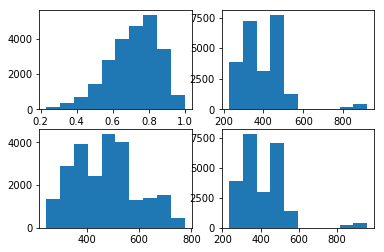

In [86]:
plt.subplot(2, 2, 1)
plt.hist(data[:, feature_dict['lt_score']])
plt.subplot(2, 2, 2)
plt.hist(data[:, feature_dict['rt_score']])
plt.subplot(2, 2, 3)
plt.hist(data[:, feature_dict['lb_score']])
plt.subplot(2, 2, 4)
plt.hist(data[:, feature_dict['rb_score']])
plt.show()

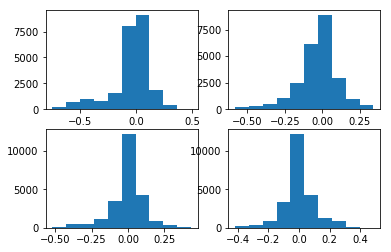

In [46]:
plt.subplot(2, 2, 1)
plt.hist(data[:, feature_dict['lt_deg']])
plt.subplot(2, 2, 2)
plt.hist(data[:, feature_dict['rt_deg']])
plt.subplot(2, 2, 3)
plt.hist(data[:, feature_dict['lb_deg']])
plt.subplot(2, 2, 4)
plt.hist(data[:, feature_dict['rb_deg']])
plt.show()

In [106]:
import random
img_indice = range(len(folder_names))
img_indice_train = random.sample(img_indice, int(len(img_indice) * 0.7))
data_train = []
data_test = []
labels_train = []
labels_test = []
metadata_train = []
metadata_test = []

# split data (don't split image)
for i in range(len(data)):
    if metadata[i] in img_indice_train:
        data_train.append(data[i])
        labels_train.append(labels[i])
        metadata_train.append(metadata[i])
    else:
        data_test.append(data[i])
        labels_test.append(labels[i])
        metadata_test.append(metadata[i])
data_train = np.array(data_train)
data_test = np.array(data_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
metadata_train = np.array(metadata_train)
metadata_test = np.array(metadata_test)

In [107]:
print(len(data_train), len(data_test), sum(labels_train), sum(labels_test))

19400 8500 30 13


In [108]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
data_train = stdsc.fit_transform(data_train)
data_test = stdsc.transform(data_test)

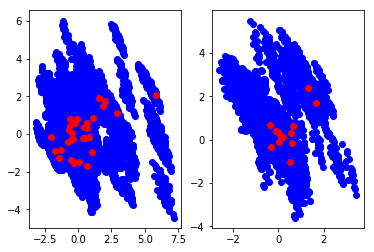

In [109]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_train)
transformed_train = pca.fit_transform(data_train)
transformed_test = pca.transform(data_test)

plt.subplot(1, 2, 1)
plt.scatter(transformed_train[labels_train==0][:,0], transformed_train[labels_train==0][:,1], c='blue')
plt.scatter(transformed_train[labels_train==1][:,0], transformed_train[labels_train==1][:,1], c='red')
plt.subplot(1, 2, 2)
plt.scatter(transformed_test[labels_test==0][:,0], transformed_test[labels_test==0][:,1], c='blue')
plt.scatter(transformed_test[labels_test==1][:,0], transformed_test[labels_test==1][:,1], c='red')
plt.show()

In [57]:
def rank_accuracy(true_labels, pred_vals, metadata, n_tol=1):
    positive_vals = pred_vals
    if pred_vals.ndim == 2:  # case of predict_proba
        positive_vals = pred_vals[:, 1]
    indice = np.argsort(positive_vals)[::-1]  # descending order
    err_count = {m: 0 for m in np.unique(metadata)}
    corrects = []
    errors = []
    for idx in indice:
        m = metadata[idx]
        if m in corrects or m in errors:
            continue
        if true_labels[idx] == 1:
            corrects.append(m)
        else:
            err_count[m] += 1
            if err_count[m] >= n_tol:
                errors.append(m)
        
    return len(corrects) / len(err_count)

## Balanced RandomForest Classifier

In [110]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100)
brf.fit(data_train, labels_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [111]:
pred_train = brf.predict(data_train)
pred_test = brf.predict(data_test)
print(confusion_matrix(labels_train, pred_train))
print(confusion_matrix(labels_test, pred_test))

[[16646  2724]
 [    0    30]]
[[7870  617]
 [   1   12]]


In [112]:
print(rank_accuracy(labels_train, brf.predict_proba(data_train), metadata_train))
print(rank_accuracy(labels_test, brf.predict_proba(data_test), metadata_test))

0.42424242424242425
0.14285714285714285


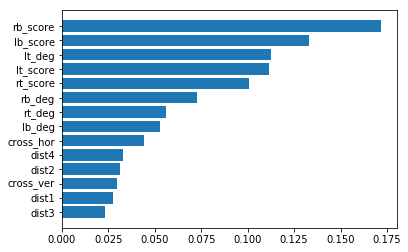

In [66]:
features = np.array(colnames[4:])
importances = brf.feature_importances_
indice = np.argsort(importances)
plt.barh(range(len(indice)), importances[indice])
plt.yticks(range(len(indice)), features[indice])
plt.show()

# BorderlineSMOTE

In [91]:
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import BorderlineSMOTE
data_bsmote, labels_bsmote = BorderlineSMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_bsmote == 0), sum(labels_bsmote == 1))

15977 7988


In [92]:
lr = LogisticRegressionCV(cv=5)
lr.fit(data_bsmote, labels_bsmote)

/home/denjo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/denjo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/denjo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/denjo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/denjo/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iter

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [93]:
pred_train = lr.predict(data_train)
pred_test = lr.predict(data_test)
print(confusion_matrix(labels_train, pred_train))
print(confusion_matrix(labels_test, pred_test))

[[15843   134]
 [   15     8]]
[[7566  196]
 [   9    4]]


In [94]:
svm = SVC(gamma='auto')
svm.fit(data_train, labels_train)
svm.fit(data_test, labels_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
pred_train = svm.predict(data_train)
pred_test = svm.predict(data_test)
print(confusion_matrix(labels_train, pred_train))
print(confusion_matrix(labels_test, pred_test))

[[15977     0]
 [   23     0]]
[[7762    0]
 [  13    0]]


## Save model

In [113]:
import pickle

clf = brf
with open('ml_model2.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [114]:
clf

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)